In [2]:
import torch
import matplotlib.pyplot as plt
import gzip
from PIL import Image, ImageOps
import numpy as np
import os
from skimage import color, data, restoration
from scipy import ndimage
from metric import get_BRISQUE_score
import av
import os
import torch
import time
from utils import CNN, AutoEncoder

def sharpen(image,psf, display=True, quality = True):
    image_offset = image.copy()/255.
    image_offset += 1e-10
    sharpened = restoration.richardson_lucy(image_offset, psf, iterations=30)
    sharpened = sharpened
    
    if display:
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
        plt.gray()
        for a in (ax[0], ax[1]):
            a.axis('off')

        ax[0].imshow(image)
        ax[0].set_title('Original Data')

        ax[1].imshow(sharpened, vmin=image.min(), vmax=image.max())
        ax[1].set_title('Restoration using\nRichardson-Lucy')

        fig.subplots_adjust(wspace=0.02, hspace=0.2, top=0.9, bottom=0.05, left=0, right=1)
        plt.show()

    if quality:
        original = Image.fromarray(np.uint8(image))
        sharp = Image.fromarray(np.uint8(sharpened*255.))
        original.save('original.png')
        sharp.save('sharp.png')
        return sharpened, get_score('original.png'), get_score('sharp.png')
    else:
        return sharpened, 0, 0


def video_preprocess(video_path, disp=True):
    im_size = 224
    v = av.open(video_path)
    video_set = np.zeros((100,224,224,3))
        
    sampling = np.linspace(0,v.streams.video[0].frames,100,dtype=int)
    for vidx,frame in enumerate(v.decode(video=0)):
        if vidx not in sampling:
            continue
        img_pil = frame.to_image()
        img_npy = np.array(img_pil)
        img_npy = np.transpose(img_npy,(1,0,2))
        img_pil = Image.fromarray(img_npy)
        img_pil = img_pil.transpose(Image.FLIP_LEFT_RIGHT)
        img_npy = np.array(img_pil)[50:-50,100:-25,:]
        img_pil = Image.fromarray(img_npy)
        img_pil = img_pil.resize((im_size,im_size))
        img_pil = np.array(img_pil)
        psf = np.random.beta(1,1,size=(3,3,1))
        sharpened, _, _ = sharpen(img_pil,psf,False,False)
        sharpened_img = Image.fromarray(np.uint8(sharpened*255.))
        video_set[np.where(sampling==vidx)[0][0]] = sharpened
        if np.where(sampling==vidx)[0][0] in [10,50,90] and disp:
            plt.figure(figsize=(10,5))
            plt.subplot(1,2,1)
            plt.imshow(frame.to_image())
            plt.subplot(1,2,2)
            plt.imshow(sharpened_img)
    video_set = np.expand_dims(video_set, axis=0)
    video_set = np.transpose(video_set,(0,2,3,1,4))
    video_set = np.reshape(video_set,(1,im_size,im_size,-1))
    video_set = np.transpose(video_set,(0,3,1,2))
    images = torch.tensor(video_set,dtype=torch.float32)
    return images
    
def Infer(video_path, model_path):
    processed_data = video_preprocess(video_path)
    processed_data = processed_data
    model = CNN(num_classes=2)
    label_set = ["Non-Malicious","Malicious"]
    if os.path.exists(model_path) == True:
        state = torch.load(model_path, map_location=torch.device('cpu'))
        model.load_state_dict(state['model']) 
    else:
        raise Exception('Model path does not exist!')
    model_output = model(processed_data).detach().numpy()
    prediction = label_set[np.argmax(model_output[0])]
    return prediction    

/vulcanscratch/vinoj/vinoj/own/Thermal_Anomaly_Detection/utils.py:143: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


The prediction for demo/demo_1.MOV is: Non-Malicious
Inference run on CPU took 45.48862290382385 seconds


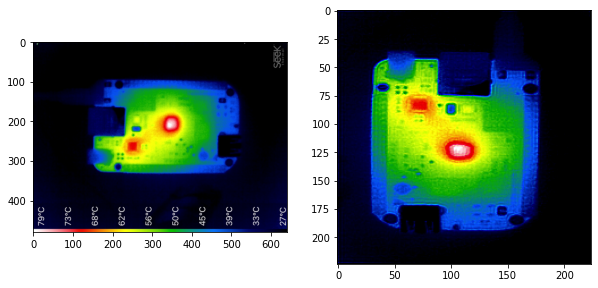

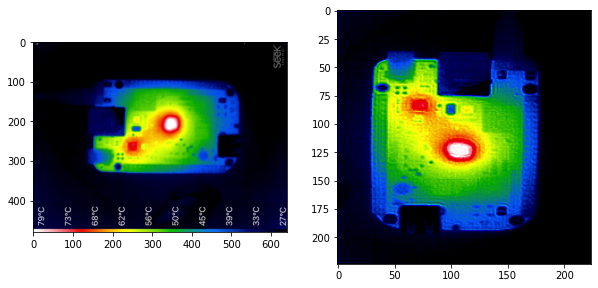

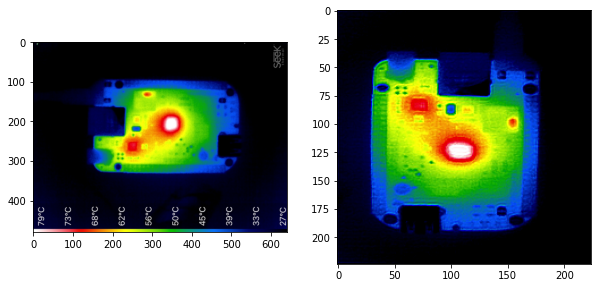

In [3]:
video_file = 'demo/demo_1.MOV'
model_path = 'results/cnn.pt'

start_time = time.time()
prediction = Infer(video_path = video_file, model_path=model_path)
end_time = time.time()
print("The prediction for {} is: {}".format(video_file,prediction))
print("Inference run on CPU took {} seconds".format(end_time-start_time))

The prediction for demo/demo_2.MOV is: Malicious
Inference run on CPU took 46.4449405670166 seconds


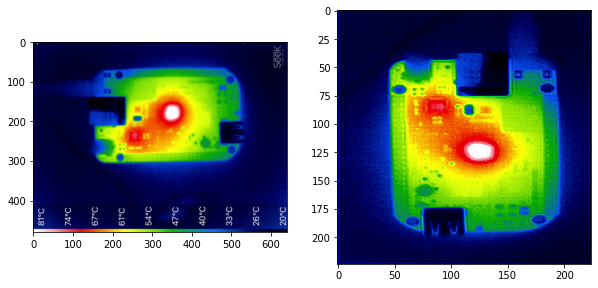

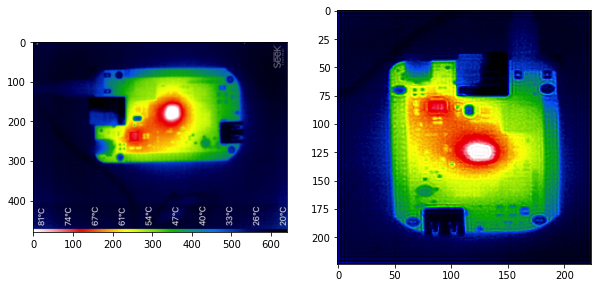

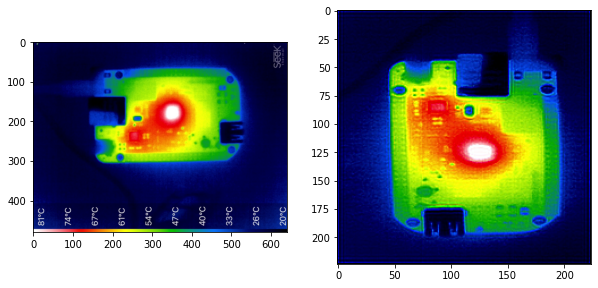

In [4]:
video_file = 'demo/demo_2.MOV'

start_time = time.time()
prediction = Infer(video_path = video_file, model_path=model_path)
end_time = time.time()
print("The prediction for {} is: {}".format(video_file,prediction))
print("Inference run on CPU took {} seconds".format(end_time-start_time))